In [32]:
%matplotlib inline

import os
import sys
import glob
import pprint

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display
from scipy.stats import linregress

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

In [33]:
# Global configurations
# ---------------------

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 12
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75

# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

Load wrangled data saved in .csv files.

In [81]:
sessions = pd.read_csv('data/sessions.csv', index_col=0)
pilots = pd.read_csv('data/pilots.csv', index_col=0)
units = pd.read_csv('data/units.csv', index_col=0)

Derive number of units requested and number of units rescheduled due to pilot halted/migrated by condor

In [82]:
sessions.loc[(sessions['nunit'] >= 8   ) & (sessions['nunit'] < 16  ), 'nunit_requested'] = 8
sessions.loc[(sessions['nunit'] >= 16  ) & (sessions['nunit'] < 32  ), 'nunit_requested'] = 16
sessions.loc[(sessions['nunit'] >= 32  ) & (sessions['nunit'] < 64  ), 'nunit_requested'] = 32
sessions.loc[(sessions['nunit'] >= 64  ) & (sessions['nunit'] < 128 ), 'nunit_requested'] = 64
sessions.loc[(sessions['nunit'] >= 128 ) & (sessions['nunit'] < 256 ), 'nunit_requested'] = 128
sessions.loc[(sessions['nunit'] >= 256 ) & (sessions['nunit'] < 512 ), 'nunit_requested'] = 256
sessions.loc[(sessions['nunit'] >= 512 ) & (sessions['nunit'] < 1024), 'nunit_requested'] = 512
sessions.loc[(sessions['nunit'] >= 1024) & (sessions['nunit'] < 2048), 'nunit_requested'] = 1024
sessions.loc[(sessions['nunit'] >= 2048) & (sessions['nunit'] < 4096), 'nunit_requested'] = 2048

sessions['nunit_rescheduled'] = sessions['nunit'] - sessions['nunit_requested']

In [83]:
display(units['U_AGENT_EXECUTING'].dropna().shape)
display(sessions['nunit_done'].sum())
pd.concat(
    [units.loc[units['U_AGENT_EXECUTING'].notnull()].groupby('sid').count()[['U_AGENT_EXECUTING']],
     sessions.loc[sessions['nunit_done'].isnull()]['nunit_done']], axis=1, join='inner')

(49525,)

49638.0

,U_AGENT_EXECUTING,nunit_done


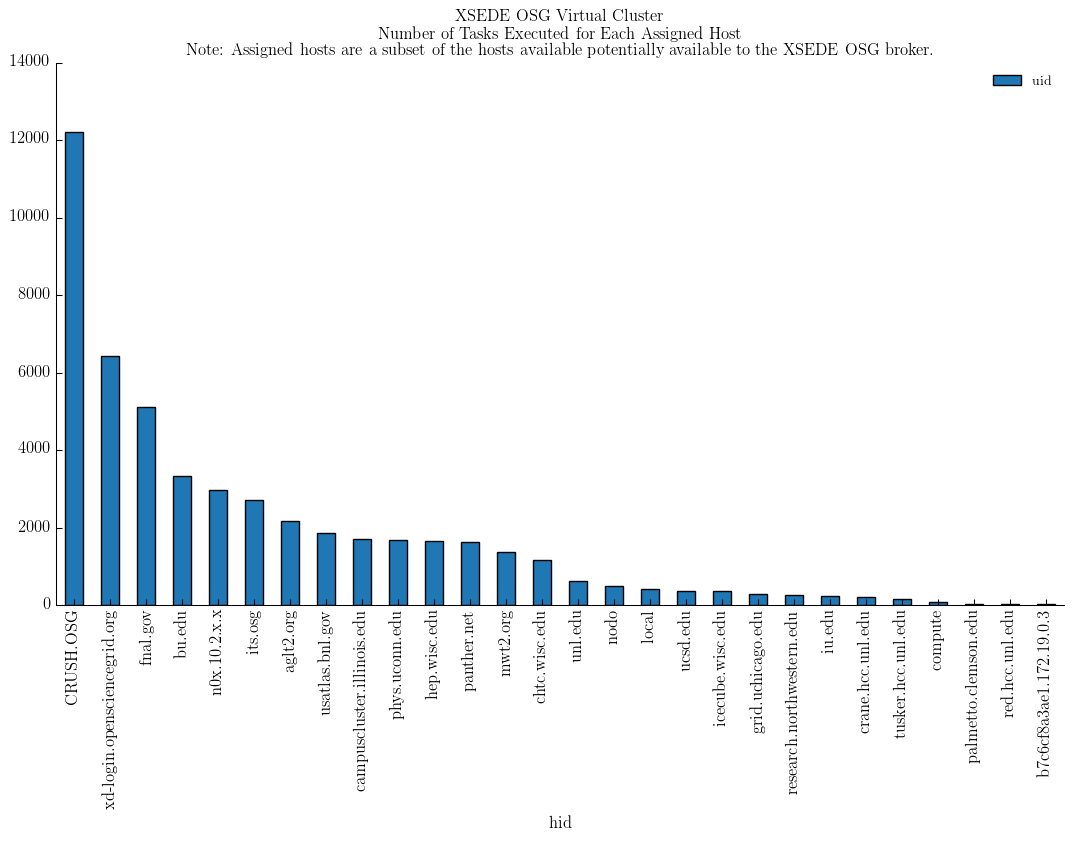

In [84]:
# TODO: Number of successful Task executions per host (x = hosts; y = number of executed tasks)

fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nNumber of Tasks Executed for Each Assigned Host\n'+\
'Note: Assigned hosts are a subset of the hosts available potentially available to the XSEDE OSG broker.'

us = units.loc[units['U_AGENT_EXECUTING'].notnull()]
us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False).plot.bar(ax=ax, color=tableau20[0], title=title)

#plt.savefig('figures/osg_nunits_per_host.pdf', dpi=600, bbox_inches='tight')

,uid
hid,
n0x.10.2.x.x,9741
xd-login.opensciencegrid.org,2463
CRUSH.OSG,1400
tusker.hcc.unl.edu,96
bu.edu,25
phys.uconn.edu,24
panther.net,15
chtc.wisc.edu,11
nodo,6


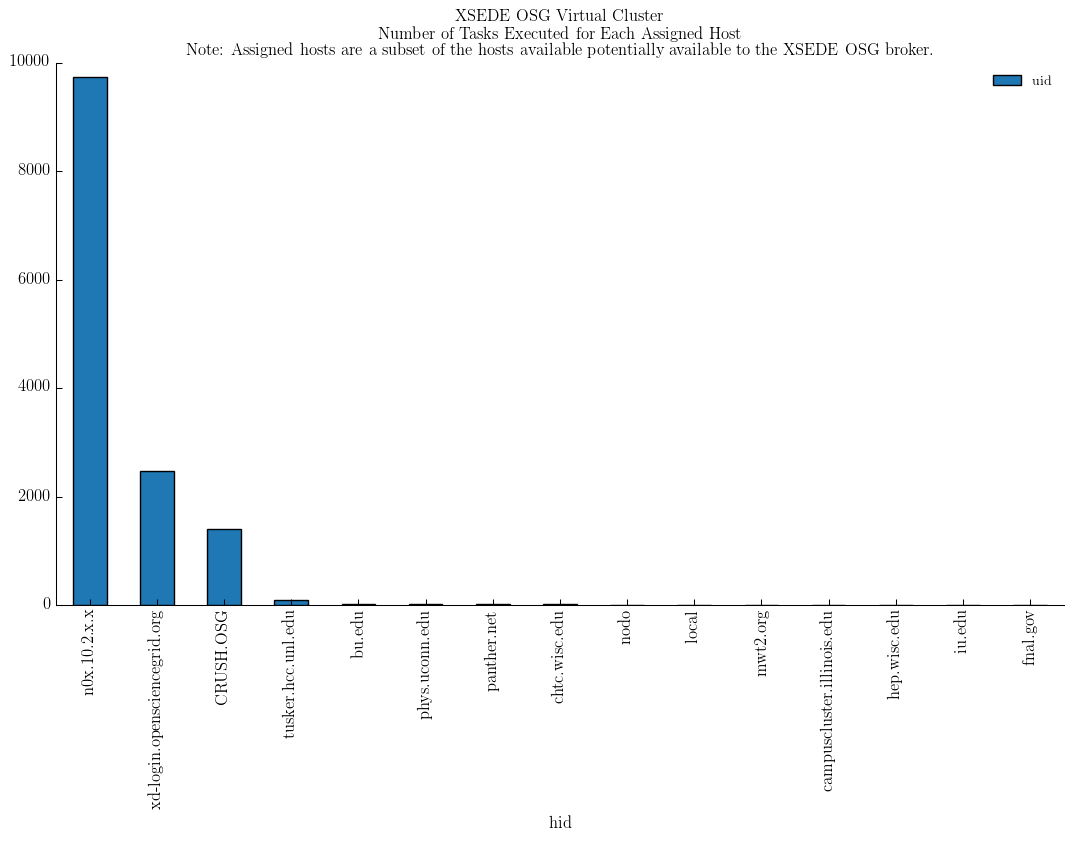

In [85]:
# TODO: Number of failed Task executions per host (x = hosts; y = number of failed tasks)

fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nNumber of Tasks Executed for Each Assigned Host\n'+\
'Note: Assigned hosts are a subset of the hosts available potentially available to the XSEDE OSG broker.'

us = units.loc[units['U_AGENT_EXECUTING'].isnull()]
display(us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False))
us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False).plot.bar(ax=ax, color=tableau20[0], title=title)

#plt.savefig('figures/osg_nunits_per_host.pdf', dpi=600, bbox_inches='tight')

In [86]:
# TODO: Number of requsted pilots Vs number of active pilots (x = sessions; y = integers)

In [87]:
# TODO: Number of unit rescheduled Vs TTC (x = TTC; y = number of units rescheduled)

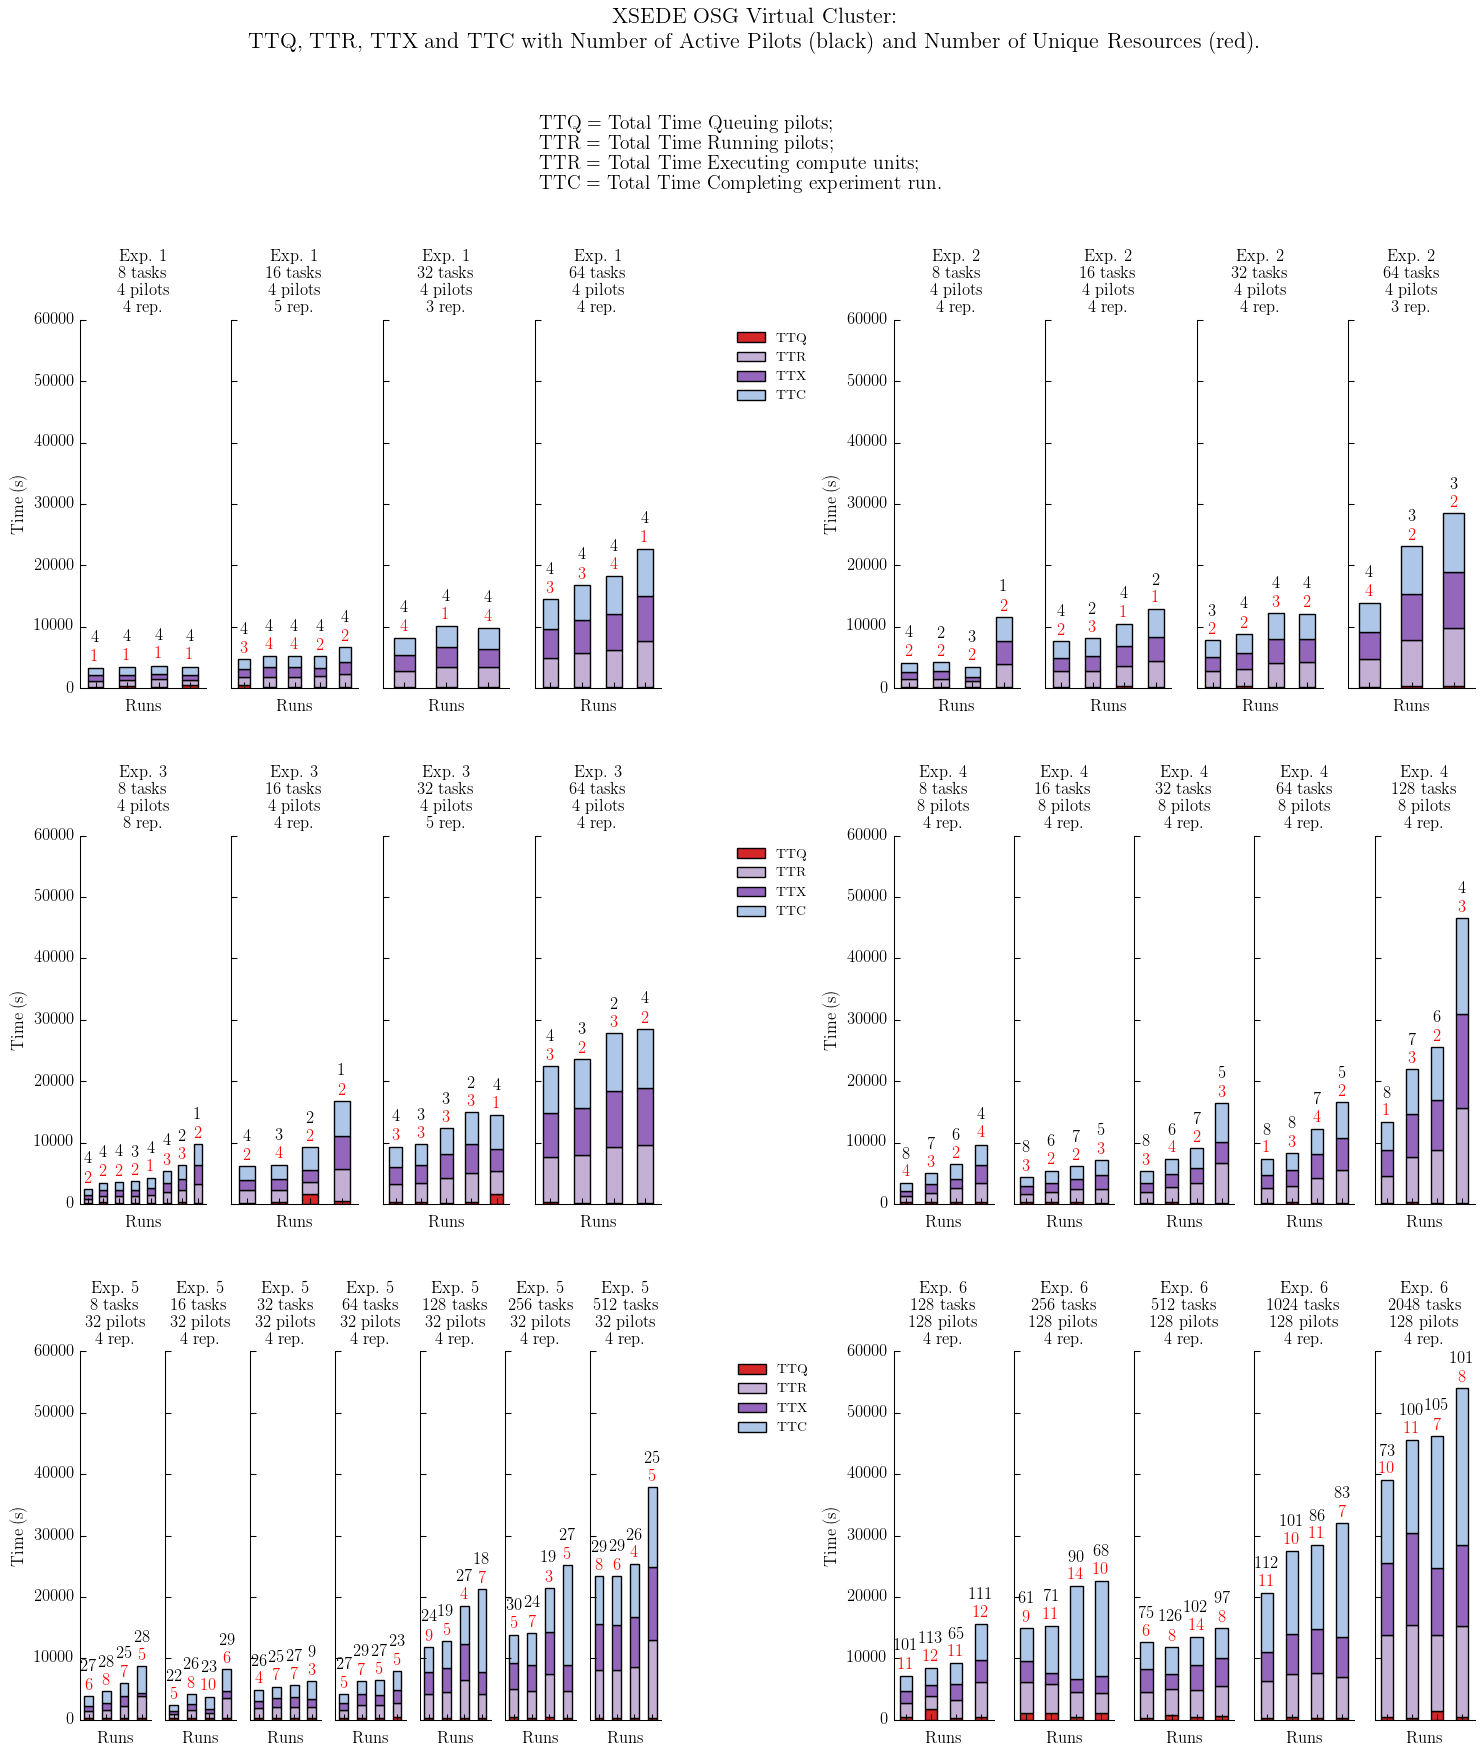

In [88]:
fig = plt.figure(figsize=(18,20))

title = 'XSEDE OSG Virtual Cluster'
subtitle = 'TTQ, TTR, TTX and TTC with Number of Active Pilots (black) and Number of Unique Resources (red)'
fig.suptitle('%s:\n%s.' % (title, subtitle), fontsize=16)

defs = {'ttq': 'TTQ = Total Time Queuing pilots',
        'ttr': 'TTR = Total Time Running pilots',
        'ttx': 'TTR = Total Time Executing compute units',
        'ttc': 'TTC = Total Time Completing experiment run'}
defslist = '%s;\n%s;\n%s;\n%s.' % (defs['ttq'], defs['ttr'], defs['ttx'], defs['ttc'])
plt.figtext(.38,.89, defslist, fontsize=14, ha='left')

gs = []
grid  = gridspec.GridSpec(3, 2)
grid.update(wspace=0.4, hspace=0.4, top=0.825)
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[2]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=grid[3]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 7, subplot_spec=grid[4]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=grid[5]))

ttq_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunit_requested'].sort_values().unique():
        if not sessions[(sessions['experiment'] == exp) & (sessions['nunit_requested'] == nun)].empty:
            ttq_subplots.append(sessions[(sessions['experiment'] == exp) & (sessions['nunit_requested'] == nun) ].sort_values('TTC'))

colors = {'exp1': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
          'exp2': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
          'exp3': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
          'exp4': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
          'exp5': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]],
          'exp6': [tableau20[6] ,tableau20[9],tableau20[8] ,tableau20[1]]}


nun_exp = []
nun_exp.append(len(sessions[sessions['experiment'] == 'exp1']['nunit_requested'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp2']['nunit_requested'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp3']['nunit_requested'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp4']['nunit_requested'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp5']['nunit_requested'].sort_values().unique()))
nun_exp.append(len(sessions[sessions['experiment'] == 'exp6']['nunit_requested'].sort_values().unique()))

ax = []
i  = 0
while(i < len(ttq_subplots)):
    for gn in range(6):
        for gc in range(nun_exp[gn]):
            session = ttq_subplots.pop(0)
            experiment = session['experiment'].unique()[0]
            ntasks = int(session['nunit'].unique()[0])
            npilots = int(session[session['experiment'] == experiment]['npilot'][0])
            repetitions = session.shape[0]
            color = colors[experiment]
            title = 'Exp. %s\n%s tasks\n%s pilots\n%s rep.' % (experiment[3], ntasks, npilots, repetitions)
            
            if i == 0:
                ax.append(plt.Subplot(fig, gs[gn][0, gc]))
            else:
                ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))
            session[['P_LRMS_QUEUING', 
                     'P_LRMS_RUNNING',
                     'U_AGENT_EXECUTING',
                     'TTC']].plot(kind='bar', ax=ax[i], color=color, title=title, stacked=True)
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].get_xaxis().tick_bottom()
            ax[i].get_yaxis().tick_left()
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('Runs')
            
            # Handle a bug that sets yticklabels to visible 
            # for the last subplot.
            if i == 7 or i == 16 or i == 28:
                plt.setp(ax[i].get_yticklabels(), visible=False)
            else:
                ax[i].set_ylabel('Time (s)')
                
            # Handle legens.
            if i == 3 or i == 11:
                ax[i].legend(labels=['TTQ','TTR','TTX','TTC'], bbox_to_anchor=(2.25, 1))
            elif i == 23:
                ax[i].legend(labels=['TTQ','TTR','TTX','TTC'], bbox_to_anchor=(3.25, 1))
            else:
                ax[i].get_legend().set_visible(False)
                
            # Add labels.
            rects = ax[i].patches
            label_np = [int(l) for l in session['npilot_active']]
            label_nh = [int(l) for l in session['nhost']]
            nh = [r.get_height() for r in rects]
            n = len(nh)/4              # Number of groups of 4 stacked bars
            # partition the list of heights nh into number of bars n partitions;
            # zip partitions into tuples t of n stacked bars;
            # sum eacth tuple into the hight of n stacked bars.
            heights = [sum(t) for t in zip(*[nh[j:j + n] for j in xrange(0, len(nh), n)])]
            
            # Add labels with number of pilots requested per session.
            for rect, label, height in zip(rects[-repetitions:], label_np, heights):
                ax[i].text(rect.get_x() + rect.get_width()/2, 
                           height+3500, label, ha='center', va='bottom')
            
            # Add labels with number of unique resources per session.
            for rect, label, height in zip(rects[-repetitions:], label_nh, heights):
                ax[i].text(rect.get_x() + rect.get_width()/2, 
                           height+500, label, ha='center', va='bottom', color='red')

            fig.add_subplot(ax[i])
            i += 1
            
plt.savefig('figures/osg_experiment_comparison.pdf', dpi=600, bbox_inches='tight')

# Analysis Total Unit Execution Time ($TTX$)

# Analysis Total Pilot Queuing Time ($TTQ$)

# Analysis Unit Execution Time ($T_x$)

In [89]:
units['U_AGENT_EXECUTING'].dropna().describe()

count    49525.000000
mean       455.098468
std        349.616607
min        120.365900
25%        248.051300
50%        350.351000
75%        511.732200
max       5545.682500
Name: U_AGENT_EXECUTING, dtype: float64

## Distribution of $T_x$

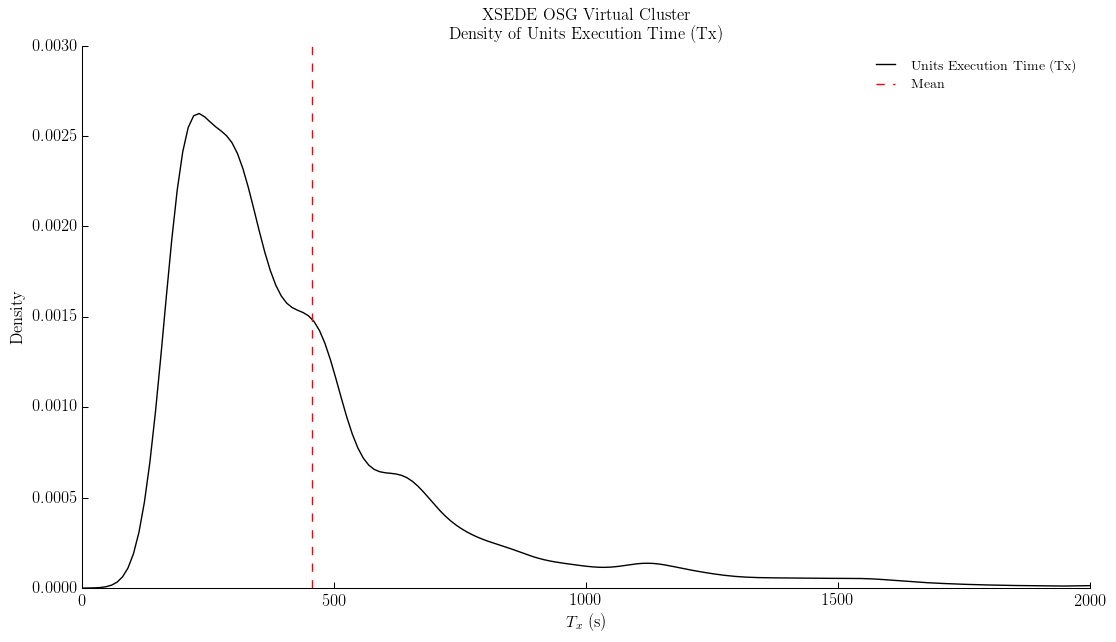

In [90]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx)'

tx_all  = units['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)

utxs = pd.DataFrame({'all': tx_all}) 

utxs.plot.density(ax=ax, color='black', title=title)
#plt.axvline(units['U_AGENT_EXECUTING'].min(),  color='r', linestyle='dashed', linewidth=1)
plt.axvline(units['U_AGENT_EXECUTING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)
#plt.axvline(units['U_AGENT_EXECUTING'].max(),  color='r', linestyle='dashed', linewidth=1)

#ax.set_xlim((0, units['U_AGENT_EXECUTING'].max()+100))
ax.set_xlim(0, 2000)
ax.set_xlabel('$T_x$ (s)')
ax.legend(labels=['Units Execution Time (Tx)', 'Mean'])

utxs.to_csv()
plt.savefig('figures/osg_tx_all_frequency.pdf', dpi=600, bbox_inches='tight')

## Comparison of the Distribution of $T_x$ per Experiment

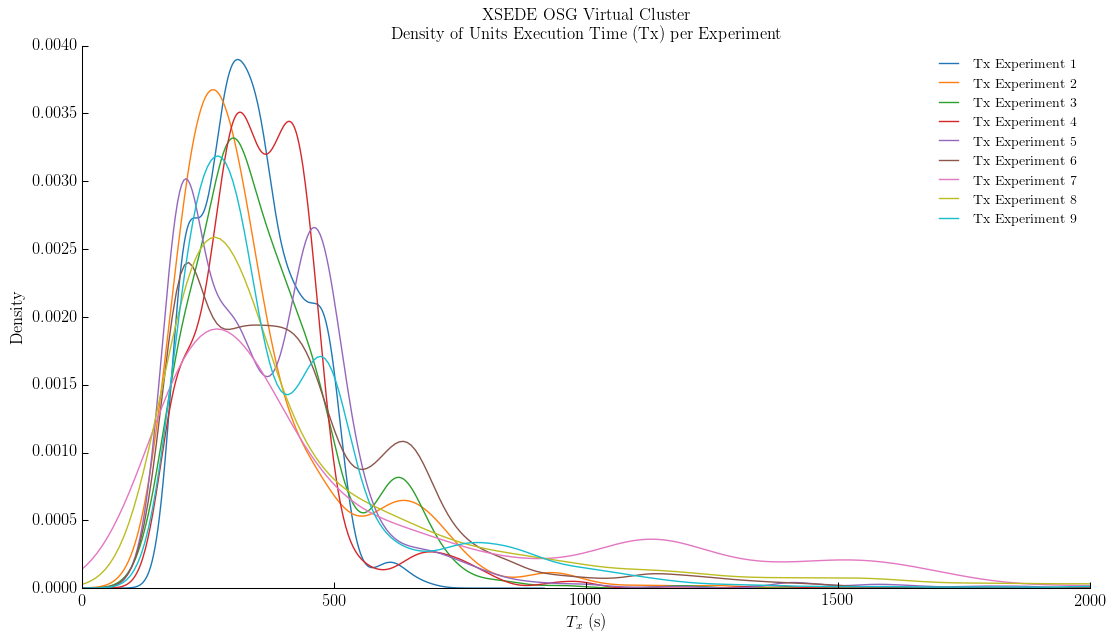

In [91]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx) per Experiment'

tx_exp1 = units[units['experiment'].str.contains('exp1')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp2 = units[units['experiment'].str.contains('exp2')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp3 = units[units['experiment'].str.contains('exp3')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp4 = units[units['experiment'].str.contains('exp4')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp5 = units[units['experiment'].str.contains('exp5')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp6 = units[units['experiment'].str.contains('exp6')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp7 = units[units['experiment'].str.contains('exp7')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp8 = units[units['experiment'].str.contains('exp8')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)
tx_exp9 = units[units['experiment'].str.contains('exp9')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)

utxs = pd.DataFrame({'exp1': tx_exp1, 'exp2': tx_exp2, 'exp3': tx_exp3, 
                     'exp4': tx_exp4, 'exp5': tx_exp5, 'exp6': tx_exp6, 
                     'exp7': tx_exp7, 'exp8': tx_exp8, 'exp9': tx_exp9})

utxs.plot.density(ax=ax, color=[tableau20[0],tableau20[2],tableau20[4],
                                tableau20[6],tableau20[8],tableau20[10],
                                tableau20[12],tableau20[14],tableau20[16]], title=title)

ax.set_xlim((0, 2000))
ax.set_xlabel('$T_x$ (s)')
ax.legend(labels=['Tx Experiment 1', 'Tx Experiment 2', 'Tx Experiment 3', 
                  'Tx Experiment 4', 'Tx Experiment 5', 'Tx Experiment 6',
                  'Tx Experiment 7', 'Tx Experiment 8', 'Tx Experiment 9'])

plt.savefig('figures/osg_tx_experiments_frequency.pdf', dpi=600, bbox_inches='tight')

## Comparison of the Distribution of Six Shuffled Partitions of the Set of Units

In [92]:
from random import shuffle

txd_exp1 = units[units['experiment'].str.contains('exp1')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp2 = units[units['experiment'].str.contains('exp2')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp3 = units[units['experiment'].str.contains('exp3')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp4 = units[units['experiment'].str.contains('exp4')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp5 = units[units['experiment'].str.contains('exp5')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()
txd_exp6 = units[units['experiment'].str.contains('exp6')]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()

txd_all = units['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).describe()

ntx = units['U_AGENT_EXECUTING'].dropna().reset_index(drop=True).count()
txd_shuffled = units['U_AGENT_EXECUTING'].dropna().sample(n=ntx).reset_index(drop=True)

# Partions with 1/4 elements of the total set of units.
txd_shf1 = txd_shuffled[:3337].describe() 
txd_shf2 = txd_shuffled[3338:6675].describe()
txd_shf3 = txd_shuffled[6675:10012].describe()
txd_shf4 = txd_shuffled[10013:13350].describe()
txd_shf5 = txd_shuffled[13351:16688].describe()
txd_shf6 = txd_shuffled[16689:20026].describe()

tx_exp_descriptions = pd.DataFrame({'all' : txd_all,
                                    'exp1': txd_exp1, 
                                    'exp2': txd_exp2, 
                                    'exp3': txd_exp3, 
                                    'exp4': txd_exp4,
                                    'exp5': txd_exp5, 
                                    'exp6': txd_exp6,                                    
                                    'shf1': txd_shf1,
                                    'shf2': txd_shf2,
                                    'shf3': txd_shf3,
                                    'shf4': txd_shf4,
                                    'shf5': txd_shf5,
                                    'shf6': txd_shf6,})

tx_exp_descriptions

,all,exp1,exp2,exp3,exp4,exp5,exp6,shf1,shf2,shf3,shf4,shf5,shf6
count,49525.000000,464.000000,416.000000,544.000000,992.000000,4056.000000,15706.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000
mean,455.098468,338.558399,355.228207,366.691442,363.009487,381.689740,440.323678,461.320937,460.009942,451.505877,446.993415,454.881780,459.692160
std,349.616607,98.210742,174.757958,145.174483,134.266899,207.245654,265.823951,369.347240,360.405628,350.446904,326.747032,355.266389,357.624012
min,120.365900,191.190400,185.204400,136.134200,170.191000,133.432300,120.365900,120.365900,134.733100,126.717800,127.591100,127.937900,128.916400
25%,248.051300,270.311050,237.678925,275.037775,282.287225,207.928125,253.522650,252.316400,252.250400,245.548600,250.255800,244.509000,250.248700
50%,350.351000,328.333200,299.423700,332.309950,345.135050,352.329750,384.393900,355.505800,350.509800,347.377700,345.359200,345.526100,355.648600
75%,511.732200,408.390325,415.966475,442.318075,424.428400,473.357225,559.558900,511.372700,507.710600,501.841700,504.496500,510.376500,517.874300
max,5545.682500,674.719000,1258.610500,1189.620700,1382.527900,2216.327500,4135.194400,5309.456100,4639.708200,5018.966100,3884.942800,4697.950600,4598.029800


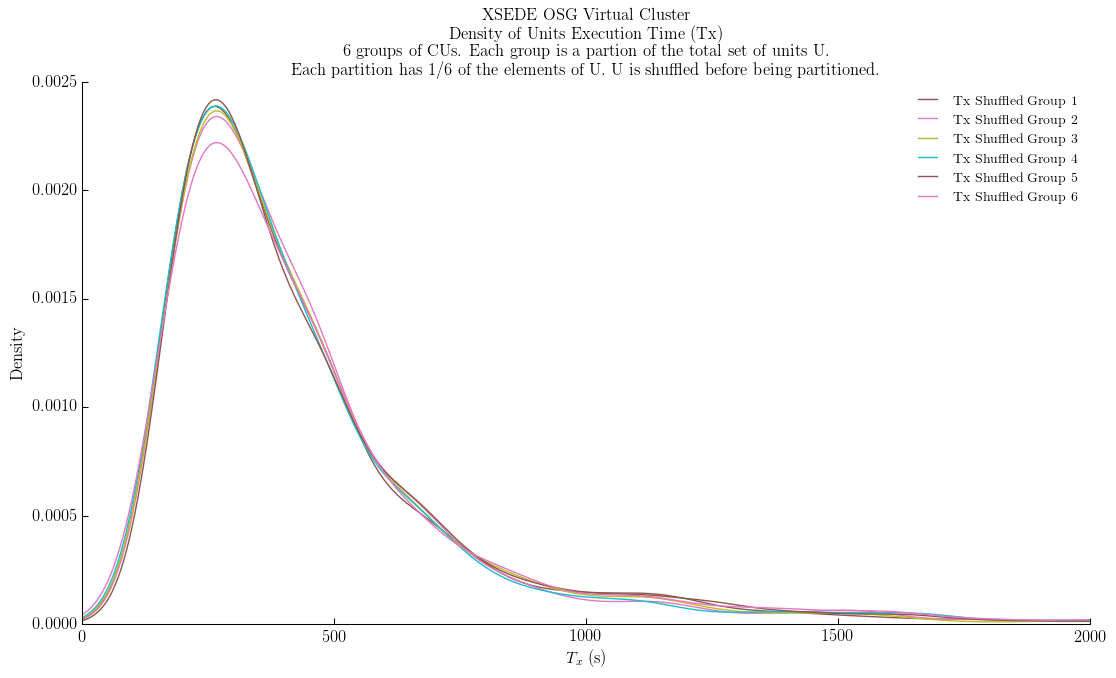

In [93]:
fig, ax = fig_setup()
resource = 'XSEDE OSG Virtual Cluster'
description = 'Density of Units Execution Time (Tx)'
explanation1 = '6 groups of CUs. Each group is a partion of the total set of units U'
explanation2 = 'Each partition has 1/6 of the elements of U. U is shuffled before being partitioned'
title='%s\n%s\n%s.\n%s.' % (resource, description, explanation1, explanation2)

txd_shuffled = units['U_AGENT_EXECUTING'].dropna().sample(n=ntx).reset_index(drop=True)
txd_shf1 = txd_shuffled[:3337].reset_index(drop=True).tolist()
txd_shf2 = txd_shuffled[3338:6675].reset_index(drop=True).tolist()
txd_shf3 = txd_shuffled[6675:10012].reset_index(drop=True).tolist()
txd_shf4 = txd_shuffled[10013:13350].reset_index(drop=True).tolist()
txd_shf5 = txd_shuffled[13351:16688].reset_index(drop=True).tolist()
txd_shf6 = txd_shuffled[16689:20026].reset_index(drop=True).tolist()


df_shf1 = pd.DataFrame(txd_shf1, columns=['shf1'])
df_shf2 = pd.DataFrame(txd_shf2, columns=['shf2'])
df_shf3 = pd.DataFrame(txd_shf3, columns=['shf3'])
df_shf4 = pd.DataFrame(txd_shf4, columns=['shf4'])
df_shf5 = pd.DataFrame(txd_shf5, columns=['shf6'])
df_shf6 = pd.DataFrame(txd_shf6, columns=['shf6'])

# txd_shfs = pd.concat([df_exp1, df_exp2, df_exp3, df_exp4, 
#                       df_shf1, df_shf2, df_shf3, df_shf4], join='outer', axis=1)
txd_shfs = pd.concat([df_shf1, df_shf2, df_shf3, 
                      df_shf4, df_shf5, df_shf6], join='outer', axis=1)

# txd_shfs.plot.density(ax=ax, title=title, color=[tableau20[0], tableau20[2], tableau20[8], tableau20[4],
#                                                  tableau20[10],tableau20[12],tableau20[14],tableau20[16]])
txd_shfs.plot.density(ax=ax, title=title, color=[tableau20[10],tableau20[12],tableau20[14],tableau20[16]])

#ax.set_xlim((0, units['U_AGENT_EXECUTING'].max()+100))
ax.set_xlim(0, 2000)
ax.set_xlabel('$T_x$ (s)')

ax.legend(labels=['Tx Shuffled Group 1','Tx Shuffled Group 2',
                  'Tx Shuffled Group 3','Tx Shuffled Group 4',
                  'Tx Shuffled Group 5','Tx Shuffled Group 6'])

plt.savefig('figures/osg_tx_shuffled_frequency.pdf', dpi=600, bbox_inches='tight')

# $T_x$ as Function of Resource Heterogeneity

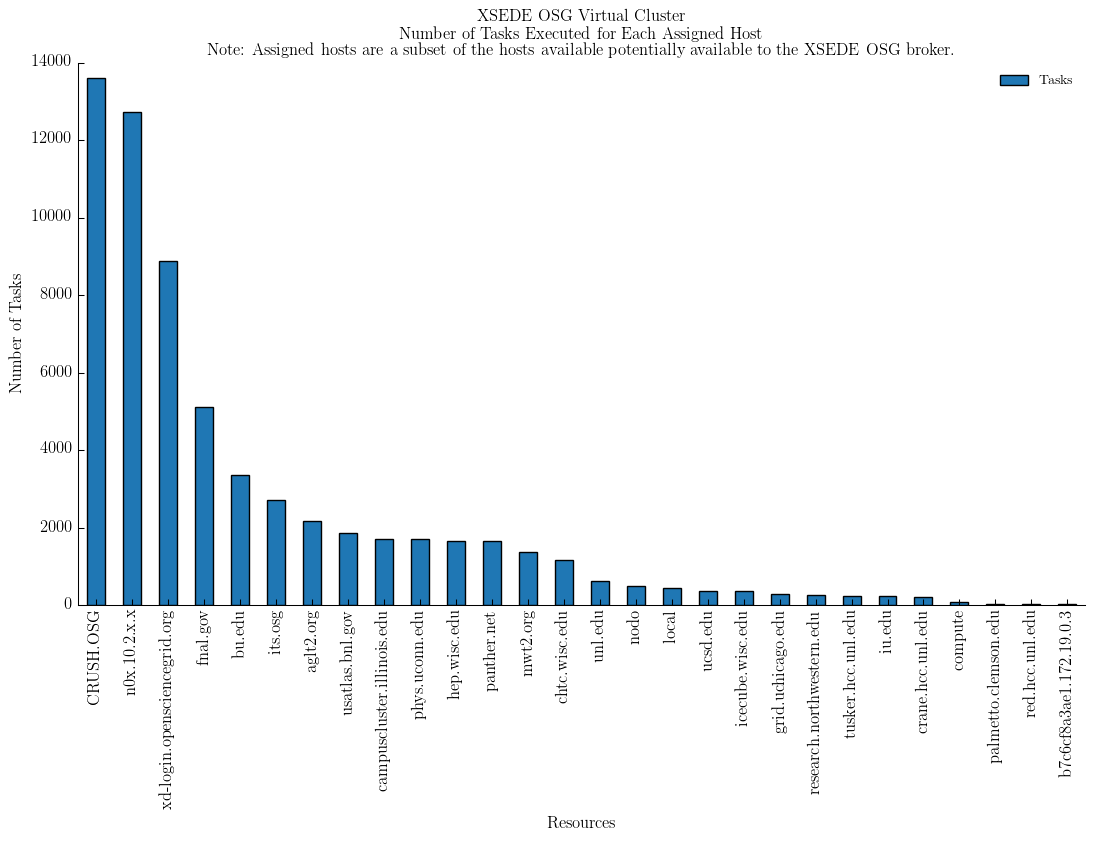

In [94]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\nNumber of Tasks Executed for Each Assigned Host\nNote: Assigned hosts are a subset of the hosts available potentially available to the XSEDE OSG broker.'

us = units
us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False).plot.bar(ax=ax, color=tableau20[0], title=title)

ax.set_xlabel('Resources')
ax.set_ylabel('Number of Tasks')
ax.legend(labels=['Tasks'])

plt.savefig('figures/osg_nunits_per_host.pdf', dpi=600, bbox_inches='tight')

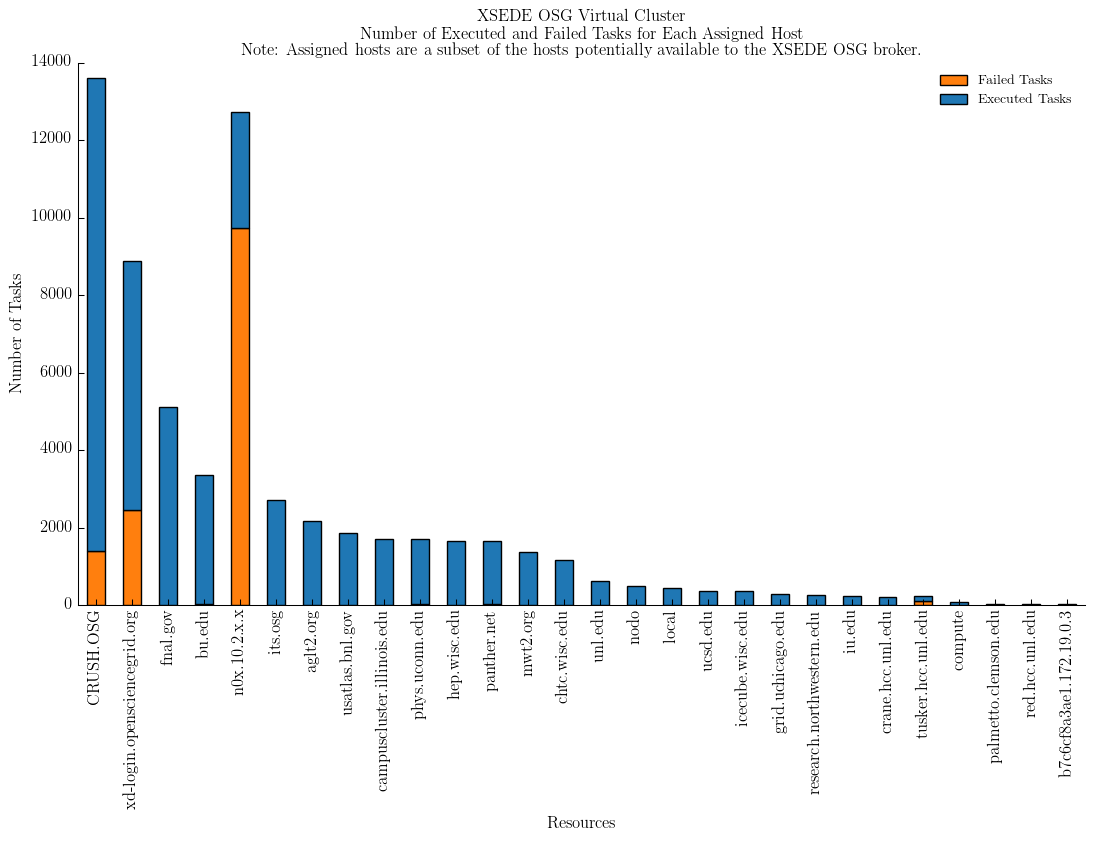

In [95]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Number of Executed and Failed Tasks for Each Assigned Host\n'+\
'Note: Assigned hosts are a subset of the hosts potentially available to the XSEDE OSG broker.'

pippo = units

pd.concat(
    [pippo.loc[pippo['U_AGENT_EXECUTING'].isnull()][['hid', 'uid']].groupby('hid').count().rename(columns={'uid':'Failed Tasks'}),
     pippo.loc[pippo['U_AGENT_EXECUTING'].notnull()][['hid', 'uid']].groupby('hid').count().rename(columns={'uid':'Executed Tasks'})], 
    axis=1).sort_values(
        by=['Executed Tasks','Failed Tasks'], 
        ascending=False).plot.bar(
            ax=ax, 
            stacked=True, 
            color=[tableau20[2],tableau20[0]], 
            title=title)

ax.set_xlabel('Resources')
ax.set_ylabel('Number of Tasks')

plt.savefig('figures/osg_nunits_executed_failed_per_host.pdf', dpi=600, bbox_inches='tight')

In [96]:
us = units

top10hosts = us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False)[:10].index.tolist()
top08hosts = us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False)[:8].index.tolist()
tophost = us[['hid', 'uid']].groupby('hid').count().sort_values(by='uid', ascending=False)[:1].index.tolist()

# display(us['U_AGENT_EXECUTING'].dropna().describe())
# display(us[us['hid'].isin(top10hosts)]['U_AGENT_EXECUTING'].dropna().describe())
# display(us[us['hid'].isin(top08hosts)]['U_AGENT_EXECUTING'].dropna().describe())
# display(us[us['hid'].isin(tophost)]['U_AGENT_EXECUTING'].dropna().describe())

us[us['U_AGENT_EXECUTING'] <= 0.4]


,U_AGENT_EXECUTING,U_AGENT_QUEUING,U_AGENT_QUEUING_EXEC,U_AGENT_SCHEDULING,U_UMGR_BINDING,U_UMGR_SCHEDULING,experiment,hid,pid,sid,uid


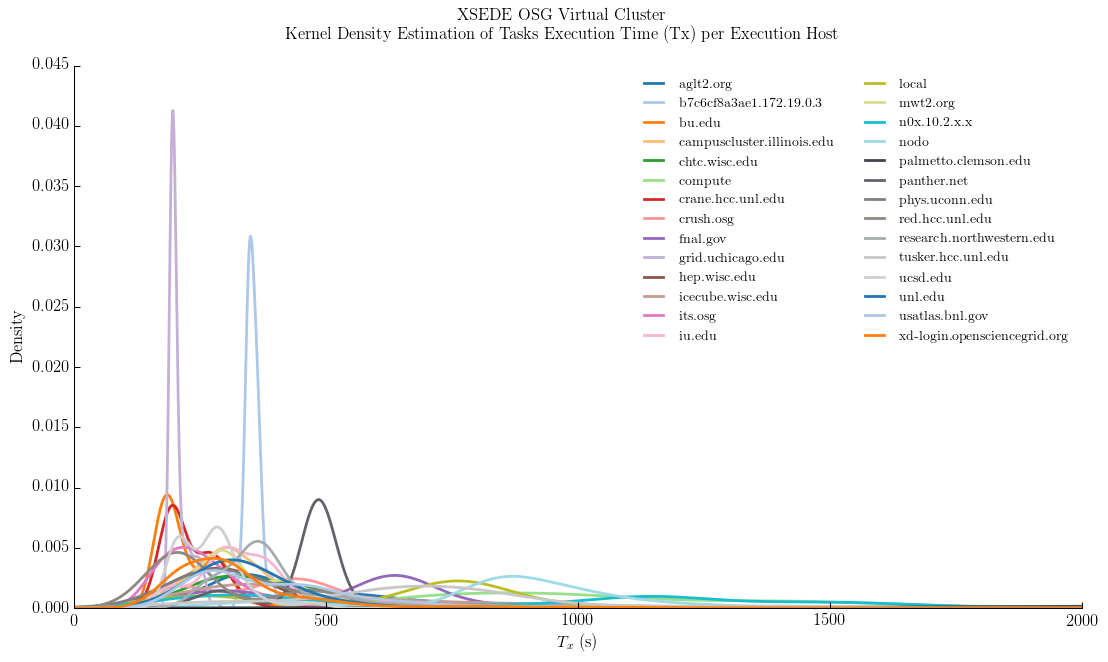

In [97]:
fig, ax = fig_setup()

# mpl.rcParams['text.usetex'] = True 
# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.serif']  = ['Helvetica']

# mpl.rcParams['legend.frameon']  = False
# mpl.rcParams['patch.linewidth'] = 0.75
# mpl.rcParams['axes.linewidth']  = 0.75

# SIZE = 20
# plt.rc('font', size=SIZE)  # controls default text sizes
# plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
# plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
# plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
# plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
# plt.rc('legend', fontsize=16)  # legend fontsize
# plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111)  

title='XSEDE OSG Virtual Cluster\nKernel Density Estimation of Tasks Execution Time (Tx) per Execution Host'
fig.suptitle(title)

curves = {}
hosts = units['hid'].dropna().unique()

minni = units.loc[units['U_AGENT_EXECUTING'].notnull()]

for host in hosts:
    curves[host] = minni.loc[units['hid'] == host]['U_AGENT_EXECUTING'].dropna().reset_index(drop=True)

curves = dict((k.lower(), v) for k,v in curves.iteritems())
    
utxh = pd.DataFrame(curves) 

utxh.plot.density(ax=ax, sort_columns=True, color=tableau20, linewidth=2)#, figsize=(15, 13), title=title) # subplots=True, layout=(4,4), sharey=True, sharex=True,
# plt.axvline(units['UNIT_AGENT_EXECUTING'].min(), color='r', linestyle='dashed', linewidth=1)
# plt.axvline(units['UNIT_AGENT_EXECUTING'].mean(), color='r', linestyle='dashed', linewidth=1)
# plt.axvline(units['UNIT_AGENT_EXECUTING'].max(), color='r', linestyle='dashed', linewidth=1)

ax.legend(ncol=2)
ax.set_xlim((0, 2000))
ax.set_xlabel('$T_x$ (s)')

plt.savefig('figures/osg_tx_hosts_frequency.pdf', dpi=600, bbox_inches='tight')

In [98]:
# s['nunit_requested'].dropna().astype(int).sort_values().unique().tolist()
#s[0:1]

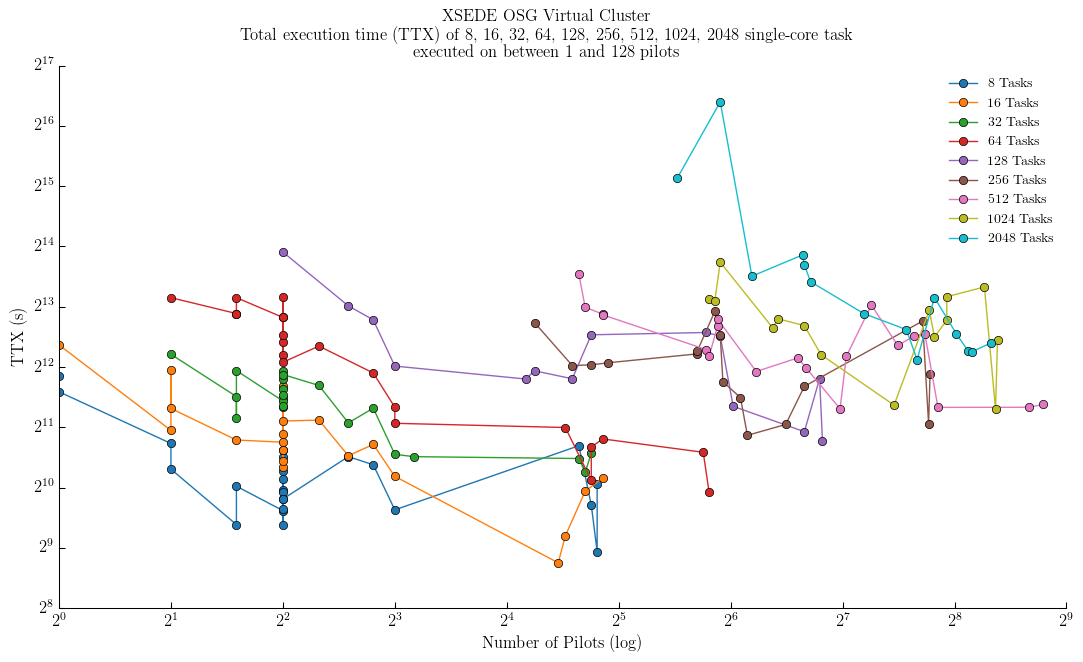

In [99]:
fig, ax = fig_setup()
fig.suptitle('XSEDE OSG Virtual Cluster\nTotal execution time (TTX) of 8, 16, 32, 64, 128, 256, 512, 1024, 2048 single-core task\nexecuted on between 1 and 128 pilots')

s = sessions.rename(columns={'npilot_active':'npilotactive'})

colors=[tableau20[0], tableau20[2],  tableau20[4],  tableau20[6], 
        tableau20[8], tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1],
        tableau20[3], tableau20[5], tableau20[7], tableau20[9],
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

for u in s['nunit_requested'].dropna().astype(int).sort_values().unique().tolist():
    unts = s[s['nunit_requested']==u][['U_AGENT_EXECUTING', 'npilotactive']].dropna().sort_values('npilotactive').copy()
    ax.plot(unts.npilotactive, unts.U_AGENT_EXECUTING, marker='o', label='%s Tasks' % u, color=colors.pop(0))

#ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.legend(numpoints=1)
ax.set_xlabel('Number of Pilots (log)')
ax.set_ylabel('TTX (s)')

plt.savefig('figures/osg_ttx_active-pilots.pdf', dpi=600, bbox_inches='tight')

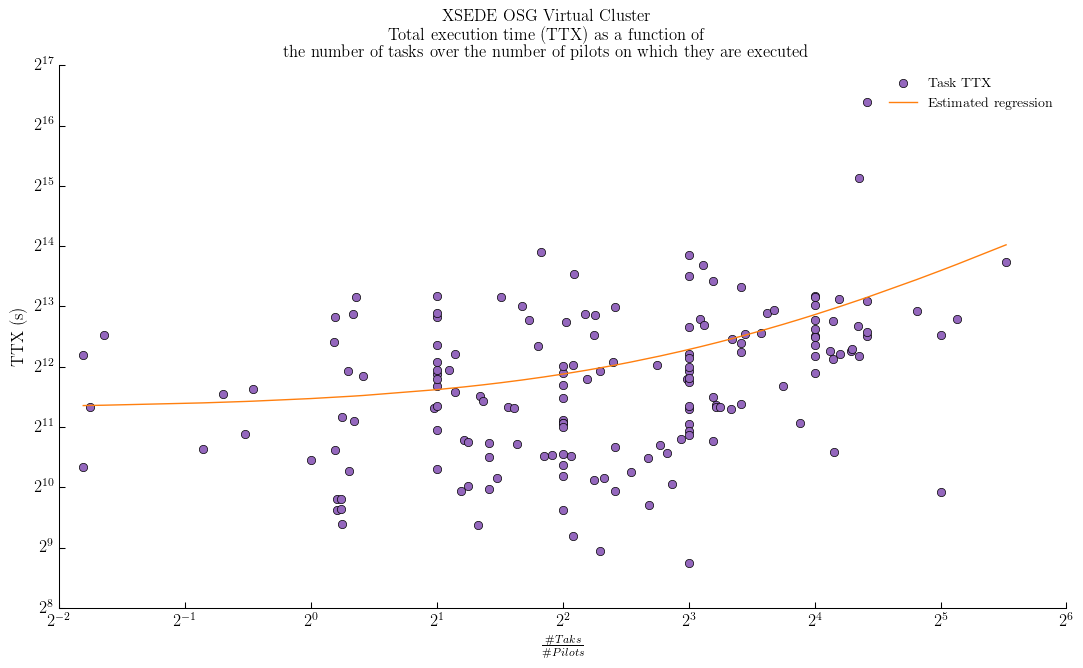

In [100]:
fig, ax = fig_setup()

fig.suptitle('XSEDE OSG Virtual Cluster\nTotal execution time (TTX) as a function of\nthe number of tasks over the number of pilots on which they are executed')

s = sessions.rename(columns={'npilot_active':'NpActive'})
s['NuOnNpActive'] = s['nunit']/s['NpActive']

x = s['NuOnNpActive'].dropna().sort_values()
y = s['U_AGENT_EXECUTING'].dropna()
fit = np.polyfit(x, y, 1)
fit_fn = np.poly1d(fit)

ax.plot(x, y, marker='o', color=tableau20[8], linestyle='', label='Task TTX')
ax.plot(x, fit_fn(x), color=tableau20[2], label='Estimated regression')

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel(r'$\frac{\#Taks}{\#Pilots}$')
plt.ylabel('TTX (s)')
ax.legend(numpoints=1)

plt.savefig('figures/osg_ttx_nunit_over_nactive-pilots.pdf', dpi=600, bbox_inches='tight')

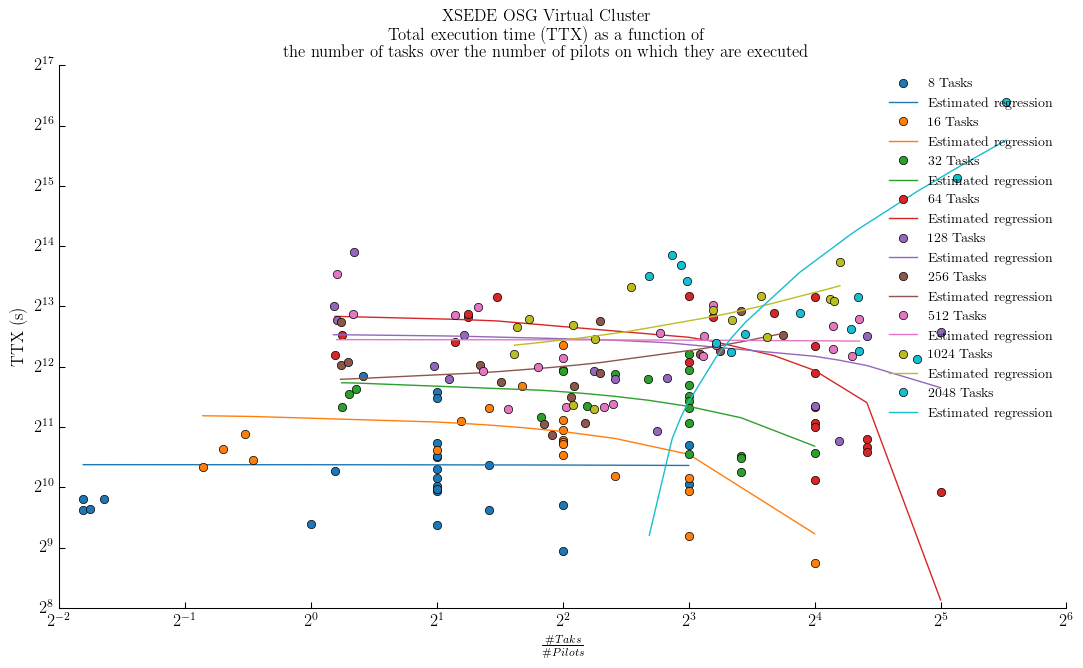

In [101]:
fig, ax = fig_setup()

fig.suptitle('XSEDE OSG Virtual Cluster\nTotal execution time (TTX) as a function of\nthe number of tasks over the number of pilots on which they are executed')

s = sessions.rename(columns={'npilot_active':'NpActive'})
s['NuOnNpActive'] = s['nunit']/s['NpActive']

colors=[tableau20[0], tableau20[2],  tableau20[4],  tableau20[6], 
        tableau20[8], tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18]]

for u in s['nunit_requested'].dropna().astype(int).sort_values().unique().tolist():
    x = s[s['nunit_requested']==u]['NuOnNpActive'].dropna().sort_values().copy()
    y = s[s['nunit_requested']==u]['U_AGENT_EXECUTING'].dropna().copy()
    fit = np.polyfit(x, y, 1)
    fit_fn = np.poly1d(fit)
    c = colors.pop(0)

    ax.plot(x, y, marker='o', linestyle='', label='%s Tasks' % u, color=c)
    ax.plot(x, fit_fn(x), color=c, label='Estimated regression')

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel(r'$\frac{\#Taks}{\#Pilots}$')
plt.ylabel('TTX (s)')
ax.legend(numpoints=1)

plt.savefig('figures/osg_ttx_nunit_over_nactive-pilots_by_bot-size.pdf', dpi=600, bbox_inches='tight')

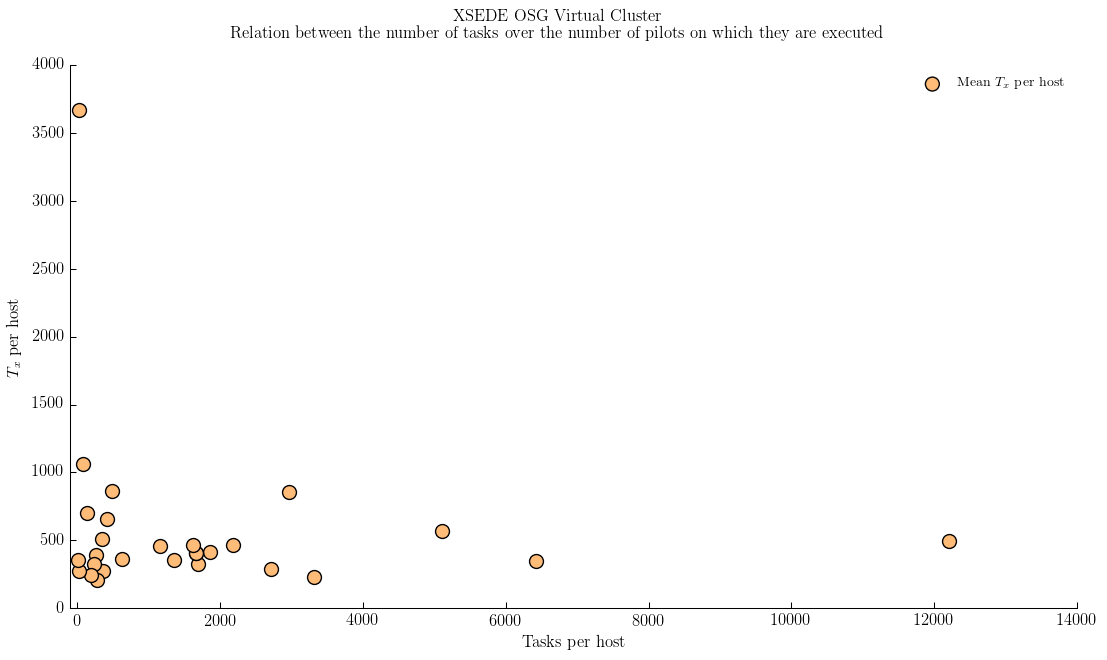

In [102]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Relation between '+\
'the number of tasks over the number of pilots on which they are executed'
fig.suptitle(title)

pluto = units
x = pluto.loc[pluto['U_AGENT_EXECUTING'].notnull()][['hid', 'uid']].groupby('hid').count()
y1 = pluto[['U_AGENT_EXECUTING', 'hid']].dropna().groupby('hid').min().add_prefix('min_')
y2 = pluto[['U_AGENT_EXECUTING', 'hid']].dropna().groupby('hid').mean().add_prefix('mean_')
y3 = pluto[['U_AGENT_EXECUTING', 'hid']].dropna().groupby('hid').max().add_prefix('max_')
scatter = pd.concat([x, y1, y2, y3], axis=1).sort_values(by='uid', ascending=False)

# display(scatter)

# scatter.plot.scatter('uid', 'min_U_AGENT_EXECUTING', s=100, ax=ax, color=tableau20[1], lw=0.5)

# ax.scatter(scatter['uid'], scatter['min_U_AGENT_EXECUTING'], s=100, facecolor=tableau20[1], label='Min $T_x$ per host')
ax.scatter(scatter['uid'], scatter['mean_U_AGENT_EXECUTING'], s=100, facecolor=tableau20[3], label='Mean $T_x$ per host')
# ax.scatter(scatter['uid'], scatter['max_U_AGENT_EXECUTING'], s=100, facecolor=tableau20[5], label='Max $T_x$ per host')

plt.xlabel('# Tasks per host')
plt.ylabel('$T_x$ per host')
ax.set_xlim((-100))
# ax.set_ylim((0, 6000))
ax.legend(scatterpoints=1)

plt.savefig('figures/osg_scatter_task-per-host_tx-per-host.pdf', dpi=600, bbox_inches='tight')

(0.99094845390186193, 32.0)

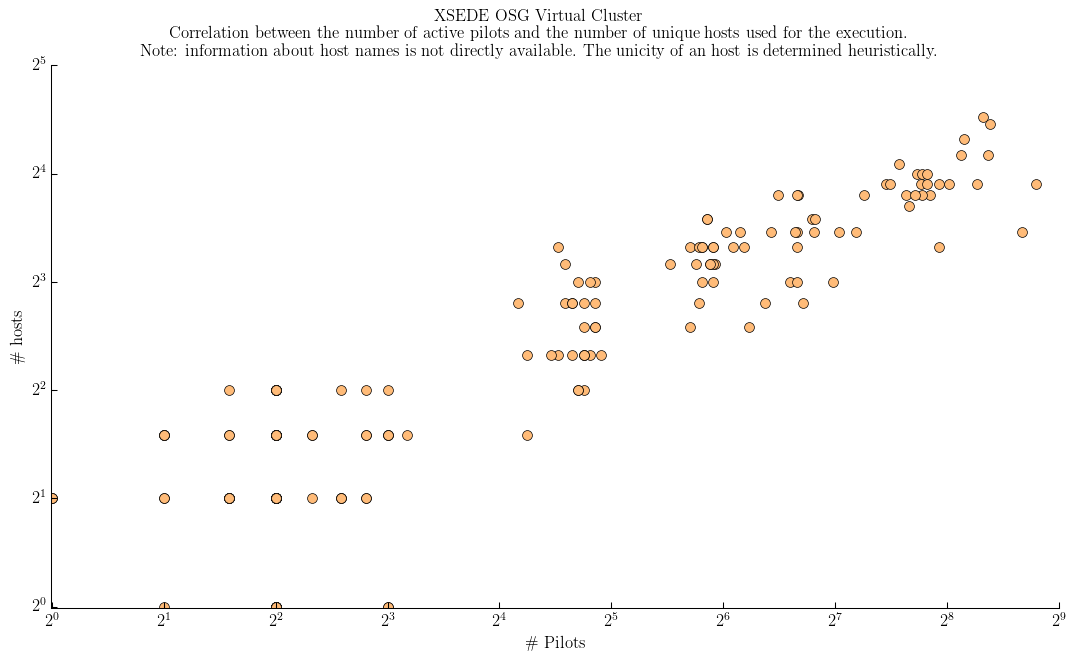

In [105]:
fig, ax = fig_setup()

title='XSEDE OSG Virtual Cluster\n'+\
'Correlation between the number of active pilots and the number of unique hosts used for the execution.\n'+\
'Note: information about host names is not directly available. The unicity of an host is determined heuristically.'
fig.suptitle(title)

paperino = sessions.copy()
ax.scatter(paperino['npilot_active'], paperino['nhost'], s=50, facecolor=tableau20[3], lw=0.5)

ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.xlabel('\# Pilots')
plt.ylabel('\# hosts')
ax.set_xlim((-10))
ax.set_ylim((0))

# plt.savefig('figures/osg_scatter_npilots-active_nhosts.pdf', dpi=600, bbox_inches='tight')

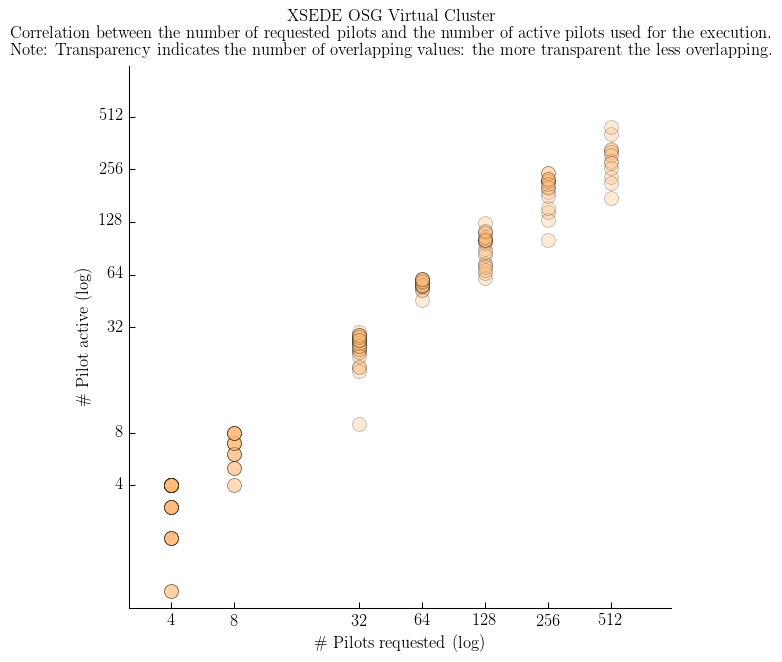

In [106]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
    
title='XSEDE OSG Virtual Cluster\n'+\
'Correlation between the number of requested pilots and the number of active pilots used for the execution.\n'+\
'Note: Transparency indicates the number of overlapping values: the more transparent the less overlapping.'
fig.suptitle(title)

qui = sessions.rename(columns={'npilot_active':'NpActive'}).copy()
ax.scatter(qui['npilot'], qui['NpActive'], s=100, facecolor=tableau20[3], alpha=0.3, lw=0.5)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((10**0.4, 10**3))#-50, 550))
ax.set_ylim((10**-0.1, 10**3))

plt.minorticks_off()
plt.xticks([4,8,32,64,128,256,512], [4,8,32,64,128,256,512])
plt.yticks([4,8,32,64,128,256,512], [4,8,32,64,128,256,512])
plt.xlabel('\# Pilots requested (log)')
plt.ylabel('\# Pilot active (log)')

plt.savefig('figures/osg_scatter_npilots-requested_npilots-active.pdf', dpi=600, bbox_inches='tight')

In [64]:
units
sessions.loc[sessions['npilot']==32]

,P_LRMS_QUEUING,P_LRMS_RUNNING,P_LRMS_SUBMITTING,P_PMGR_QUEUING,P_PMGR_SCHEDULING,TTC,U_AGENT_EXECUTING,U_AGENT_QUEUING,U_AGENT_QUEUING_EXEC,U_AGENT_SCHEDULING,...,U_UMGR_SCHEDULING,experiment,nhost,npilot,npilot_active,nunit,nunit_done,nunit_failed,nunit_requested,nunit_rescheduled
rp.session.radical.mturilli.017087.0009,396.8849,2379.4419,39.7914,0.0067,0.1965,3186.7695,2042.9982,0.094900,0.128999,1552.8354,...,0.6100,exp5,5.0,32.0,23.0,64.0,64.0,0.0,64.0,0.0
rp.session.radical.mturilli.017087.0010,451.3906,7063.3448,37.7379,0.0082,0.1894,7125.4746,6823.2177,0.398801,0.437201,6095.4376,...,0.9541,exp5,3.0,32.0,19.0,256.0,256.0,0.0,256.0,0.0
rp.session.radical.mturilli.017087.0012,230.5999,1766.6615,37.3238,0.0048,0.2144,2839.3466,1461.1407,0.039899,0.051500,1020.7037,...,0.2148,exp5,3.0,32.0,9.0,32.0,32.0,0.0,32.0,0.0
rp.session.radical.mturilli.017087.0013,231.4383,4439.9560,37.0475,0.0047,0.1951,5301.0777,4167.5563,0.531101,0.396701,3637.4170,...,0.9182,exp5,7.0,32.0,24.0,256.0,252.0,4.0,256.0,0.0
rp.session.radical.mturilli.017088.0000,253.3391,887.0765,37.8266,0.0047,0.2306,1993.0679,588.0755,0.011700,0.019400,322.8138,...,0.2050,exp5,10.0,32.0,23.0,16.0,16.0,0.0,16.0,0.0
rp.session.radical.mturilli.017088.0001,264.3490,12736.2547,36.9864,0.0038,0.1898,12967.7895,11904.6316,0.773498,0.808198,10100.7374,...,1.4799,exp5,5.0,32.0,25.0,512.0,510.0,2.0,512.0,0.0
rp.session.radical.mturilli.017088.0003,283.1689,7773.5834,37.0910,0.0058,0.2238,7781.3170,7522.3455,0.792703,0.789900,6741.0040,...,1.1071,exp5,8.0,32.0,29.0,512.0,512.0,0.0,512.0,0.0
rp.session.radical.mturilli.017088.0004,344.4402,3835.9824,36.9836,0.0080,0.2093,4126.4746,3578.8839,0.181601,0.395598,2394.1202,...,0.7916,exp5,9.0,32.0,24.0,128.0,128.0,0.0,128.0,0.0
rp.session.radical.mturilli.017088.0005,252.2844,6182.7551,37.4512,0.0050,0.3268,6190.4969,5933.8360,0.170102,0.188500,4540.6160,...,0.4905,exp5,4.0,32.0,27.0,128.0,128.0,0.0,128.0,0.0
rp.session.radical.mturilli.017088.0006,258.1318,1355.8616,40.3247,0.0060,0.1975,1525.8774,1112.3053,0.061399,0.092800,646.3374,...,0.3925,exp5,5.0,32.0,27.0,64.0,64.0,0.0,64.0,0.0
